## Multi-Armed Bandit Simulations ##
**Implementations based on White(2013)**  

In [2]:
# Import required packages
import random
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [3]:
# Rewards from the variants are Bernoulli in nature, a reward (1) would be returned with the probability p, and a
# non-reward (0) would be returned with the probability 1-p
class BernoulliArm():
  def __init__(self, p):
    self.p = p
  
  def draw(self):
    if random.random() > self.p:
      return 0.0
    else:
      return 1.0


In [4]:
# Helper function to return the index of the position that has the maximum value in a list
def ind_max(x):
  m = max(x)
  return x.index(m)

**Epsilon Greedy**  
This is one of the most popular and simple strategies for solving the multi-armed bandit problem. Here the agent selects a random variant (arm) 0≤ ϵ ≤1 fraction of the trials, and the arm with best average observed rewards 1- ϵ fraction of the time. The value of ϵ and the measure of rewards is decided based on the application.

There are different variants of the Epsilon Greedy algorithm. The most basic implementation, which is also used as our experiment baseline defines a constant value of ϵ. This is generally considered a suboptimal choice as the algorithm continues to explore with a constant rate even after enough knowledge about the rewards from different variants is acquired. In practice, therefore, strategies called Annealing Epsilon Greedy are employed, where the value of ϵ gradually decreases as the experiment progresses.


In [5]:
# Class representing the Epsilon Greedy MAB
class EpsilonGreedy():
  def __init__(self, epsilon, counts, values):
    self.epsilon = epsilon
    self.counts = counts
    self.values = values
    return

  def initialize(self, n_arms):
    self.counts = [0 for col in range(n_arms)]
    self.values = [0.0 for col in range(n_arms)]
    return

  def select_arm(self):
    if random.random() > self.epsilon:
      return ind_max(self.values)
    else:
      return random.randrange(len(self.values))
  
  def update(self, chosen_arm, reward):
    self.counts[chosen_arm] = self.counts[chosen_arm] + 1
    n = self.counts[chosen_arm]
    
    value = self.values[chosen_arm]
    new_value = ((n - 1) / float(n)) * value + (1 / float(n)) * reward
    self.values[chosen_arm] = new_value
    return


**Thompson Sampling**  
Thompson Sampling is a probabilistic algorithm based on a prior distribution. In this strategy, we assume a prior probability distribution for each of the arms, taking n samples from each of these. These initial distributions will not be the same as the true rewards distributions, but the objective is to progressively update the parameters for the priors so that they start resembling the true distributions. 

Considering Bernoulli arms for the bandit, where each arm has a probability p of generating a reward and 1 – p of not generating one, our priors can be modeled using a Beta distribution, parameterized by [alpha, beta] ∈ [0, 1]. Alpha is used to model the number of times a reward is generated, and beta represents the lack of a reward. The agent samples a value from each of the K distributions at each iteration, selecting the arm that has the highest prior mean. Based on the result of pulling that arm, the parameters alpha and beta of the prior are updated, resulting in the prior distribution eventually replicating the true distribution.

In [6]:
# Class representing the Thompson Sampling MAB
class ThompsonSampling():
  def __init__(self, counts, values, alpha, beta):
    self.counts = counts
    self.values = values
    self.alpha = alpha
    self.beta = beta
    return

  def initialize(self, n_arms):
    self.counts = [0 for col in range(n_arms)]
    self.values = [0.0 for col in range(n_arms)]
    self.alpha = [1 for col in range(n_arms)]
    self.beta = [1 for col in range(n_arms)]
    return

  def select_arm(self):
    samples = [np.random.beta(self.alpha[arm], self.beta[arm]) for arm in range(len(self.values))]
    return ind_max(samples)
  
  def update(self, chosen_arm, reward):
    self.counts[chosen_arm] = self.counts[chosen_arm] + 1
    n = self.counts[chosen_arm]
    value = self.values[chosen_arm]
    new_value = ((n - 1) / float(n)) * value + (1 / float(n)) * reward
    self.values[chosen_arm] = new_value
    if reward == 1.0:
        self.alpha[chosen_arm] += 1
    else:
        self.beta[chosen_arm] += 1
    return

**Upper Confidence Bound**  
MAB algorithms such as Epsilon Greedy have a limitation in that they only pay attention to the amount of rewards generated thus far when choosing the best arm. However the confidence in the value of those arms is not taken into consideration. So, these algorithms end up under-exploring variants where initial experiences were not rewarding, effectively being misled by a few 'negative experiences'.  

The UCB family of algorithms helps overcome this shortcoming. UCB1 is the first and simplest such strategy, which does not maintain a distinction between an exploratory phase and an exploitation phase, choosing instead to optimize how exploration happens at each individual iterate (Burtini et.al, 2015).

UCB1 begins by playing each arm once to create an initial estimate. Then, for each iterate t, arm i is selected to achieve the maximum value

\begin{align}
x & = max_{i} \bar x_{i} + \sqrt{\frac{2ln(t)}{n_i}} \\
\end{align}

where $ \bar x_{i} $ is the average observed reward of arm i thus far (the empirical mean)
and $ n_{i} $ is the number of times arm i has been played. The second term in this equation acts as an approximation for “optimism” by treating arms which have been played less as more uncertain (and thus plausibly better) than arms that
have been played frequently.

In [7]:
# Class representing the Upper Confidence Bound 1 MAB
class UCB1():
  def __init__(self, counts, values):
    self.counts = counts
    self.values = values
    return
  
  def initialize(self, n_arms):
    self.counts = [0 for col in range(n_arms)]
    self.values = [0.0 for col in range(n_arms)]
    return
  
  def select_arm(self):
    n_arms = len(self.counts)
    for arm in range(n_arms):
      if self.counts[arm] == 0:
        return arm

    ucb_values = [0.0 for arm in range(n_arms)]
    total_counts = sum(self.counts)
    for arm in range(n_arms):
      bonus = math.sqrt((2 * math.log(total_counts)) / float(self.counts[arm]))
      ucb_values[arm] = self.values[arm] + bonus
    return ind_max(ucb_values)
  
  def update(self, chosen_arm, reward):
    self.counts[chosen_arm] = self.counts[chosen_arm] + 1
    n = self.counts[chosen_arm]

    value = self.values[chosen_arm]
    new_value = ((n - 1) / float(n)) * value + (1 / float(n)) * reward
    self.values[chosen_arm] = new_value
    return

In [8]:
# Class representing the KL-UCB MAB
class KLUCB():
  def __init__(self, counts, values, qmax):
    self.counts = counts
    self.values = values
    self.qmax = qmax
    return
  
  def initialize(self, n_arms):
    self.counts = [0 for col in range(n_arms)]
    self.values = [0.0 for col in range(n_arms)]
    self.qmax = [0.0 for col in range(n_arms)]
    return
  
  def select_arm(self):
    n_arms = len(self.counts)
    for arm in range(n_arms):
      if self.counts[arm] == 0:
        return arm
    total_counts = sum(self.counts)
    self.update_qmax(total_counts)
    return ind_max(self.qmax)
  
  def update(self, pulls):
    delta = 1e-8
    epsilon = 1e-10
    for i in range(0, n_arms):
        converged = False
        p = max(self.values[i], delta)
        q = p + delta
        j = 0
        while j < 100 and not converged:
            term1 = p * math.log(p/q)
            term2 = 0
            if (1 - p) != 0:
                term2 = (1 - p) * math.log((1-p)/(1-q))                              
            kl =  term1 + term2 
            f  = math.log(pulls) / self.counts[i] - kl
            df = -(q-p) / (q * (1.0 - q))
            if f*f < epsilon:
                converged = True
                break
            q = min(1 - delta, max(q - f/df, p + delta))
            j += 1
        self.qmax[i] = q
          
  def update_avg_reward(self, chosen_arm, reward):
    self.counts[chosen_arm] = self.counts[chosen_arm] + 1
    n = self.counts[chosen_arm]
    value = self.values[chosen_arm]
    new_value = ((n - 1) / float(n)) * value + (1 / float(n)) * reward
    self.values[chosen_arm] = new_value
    return

In [9]:
# Code to perform Monte Carlo simulations on the given MAB instance (algo), for a given set of Bernoulli arms (arms)
def test_algorithm(algo, arms, num_sims, horizon):
  chosen_arms = [0.0 for i in range(num_sims * horizon)]
  rewards = [0.0 for i in range(num_sims * horizon)]
  cumulative_rewards = [0.0 for i in range(num_sims * horizon)]
  sim_nums = [0.0 for i in range(num_sims * horizon)]
  times = [0.0 for i in range(num_sims * horizon)]
  
  for sim in range(num_sims):
    sim = sim + 1
    algo.initialize(len(arms))
    
    for t in range(horizon):
      t = t + 1
      index = (sim - 1) * horizon + t - 1
      sim_nums[index] = sim
      times[index] = t
      
      chosen_arm = algo.select_arm()
      chosen_arms[index] = chosen_arm
      
      reward = arms[chosen_arms[index]].draw()
      rewards[index] = reward
      
      if t == 1:
        cumulative_rewards[index] = reward
      else:
        cumulative_rewards[index] = cumulative_rewards[index - 1] + reward
      
      algo.update(chosen_arm, reward)
  
  return [sim_nums, times, chosen_arms, rewards, cumulative_rewards]

In [33]:
# Run simulation for Epsilon Greedy with Bernoulli arms
random.seed(1)
means = [0.1, 0.9]
n_arms = len(means)
random.shuffle(means)
print("Arms after shuffling are:", means)
arms = map(lambda mu: BernoulliArm(mu), means)
print("Best arm is " + str(ind_max(means)))

epsilon = 0.1
algo_eps = EpsilonGreedy(epsilon, [], [])
results_eps = test_algorithm(algo_eps, list(arms), 100, 1000)

Arms after shuffling are: [0.9, 0.1]
Best arm is 0


In [34]:
# Run simulation for UCB with Bernoulli arms
random.seed(1)
means = [0.1, 0.9]
n_arms = len(means)
random.shuffle(means)
print("Arms after shuffling are:", means)
arms = map(lambda mu: BernoulliArm(mu), means)
print("Best arm is " + str(ind_max(means)))

algo_ucb = UCB1([], [])
results_ucb = test_algorithm(algo_ucb, list(arms), 100, 1000)

Arms after shuffling are: [0.9, 0.1]
Best arm is 0


In [35]:
# Run simulation for Thompson Sampling with 4 Bernoulli arms
random.seed(1)
means = [0.1, 0.9]
n_arms = len(means)
random.shuffle(means)
print("Arms after shuffling are:", means)
arms = map(lambda mu: BernoulliArm(mu), means)
print("Best arm is " + str(ind_max(means)))

algo_thompson = ThompsonSampling([], [], [], [])
results_thompson = test_algorithm(algo_thompson, list(arms), 100, 1000)

Arms after shuffling are: [0.9, 0.1]
Best arm is 0


In [36]:
# Transpose the resulting 2-d arrays
results_eps_t = np.array(results_eps).T.tolist()
results_ucb_t = np.array(results_ucb).T.tolist()
results_thompson_t = np.array(results_thompson).T.tolist()

In [37]:
# Name the columns in the transposed data
results_df_eps = pd.DataFrame.from_records(results_eps_t, columns=['Simulation', 'Time', 'Arm', 'Reward', 'Cumulative Reward'])
results_df_ucb = pd.DataFrame.from_records(results_ucb_t, columns=['Simulation', 'Time', 'Arm', 'Reward', 'Cumulative Reward'])
results_df_thompson = pd.DataFrame.from_records(results_thompson_t, columns=['Simulation', 'Time', 'Arm', 'Reward', 'Cumulative Reward'])

In [38]:
# Retain measures of cumulative rewards at 5 equal intervals, to reduce the number of data points for analysis
time_levels = [200,400,600,800,1000]

In [39]:
# Arrange data for analysis
comparison_eps = pd.DataFrame(results_df_eps[['Simulation', 'Time', 'Cumulative Reward']]).astype(int)
comparison_eps['Algorithm'] = 'Epsilon Greedy' # Add column to identify the algorithm
comparison_eps = comparison_eps[comparison_eps['Time'].isin(time_levels)]
comparison_eps = comparison_eps[['Simulation', 'Time', 'Algorithm', 'Cumulative Reward']].reset_index(drop = True)
comparison_eps.head(5)

,Simulation,Time,Algorithm,Cumulative Reward
0,1,200,Epsilon Greedy,176
1,1,400,Epsilon Greedy,343
2,1,600,Epsilon Greedy,518
3,1,800,Epsilon Greedy,694
4,1,1000,Epsilon Greedy,858


In [40]:
# Arrange data for analysis
comparison_ucb = pd.DataFrame(results_df_ucb[['Simulation', 'Time', 'Cumulative Reward']]).astype(int)
comparison_ucb['Algorithm'] = 'UCB' # Add column to identify the algorithm
comparison_ucb = comparison_ucb[comparison_ucb['Time'].isin(time_levels)]
comparison_ucb = comparison_ucb[['Simulation', 'Time', 'Algorithm', 'Cumulative Reward']].reset_index(drop = True)
comparison_ucb.head(5)

,Simulation,Time,Algorithm,Cumulative Reward
0,1,200,UCB,165
1,1,400,UCB,346
2,1,600,UCB,517
3,1,800,UCB,701
4,1,1000,UCB,876


In [41]:
# Arrange data for analysis
comparison_thompson = pd.DataFrame(results_df_thompson[['Simulation', 'Time', 'Cumulative Reward']]).astype(int)
comparison_thompson['Algorithm'] = 'Thompson Sampling' # Add column to identify the algorithm
comparison_thompson = comparison_thompson[comparison_thompson['Time'].isin(time_levels)]
comparison_thompson = comparison_thompson[['Simulation', 'Time', 'Algorithm', 'Cumulative Reward']].reset_index(drop = True)
comparison_thompson.head(5)

,Simulation,Time,Algorithm,Cumulative Reward
0,1,200,Thompson Sampling,169
1,1,400,Thompson Sampling,352
2,1,600,Thompson Sampling,525
3,1,800,Thompson Sampling,709
4,1,1000,Thompson Sampling,885


In [48]:
# merge the data frames along the rows, creating one combined data frame for analysis
comparison_df = pd.concat([comparison_eps, comparison_ucb, comparison_thompson])

In [49]:
comparison_df.shape

(1500, 4)

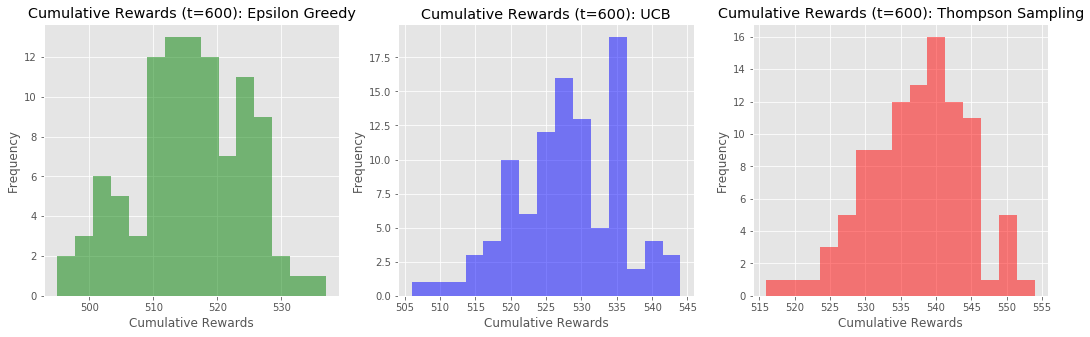

In [50]:
figure = plt.figure(figsize = (18, 5))
figure.add_subplot(1,3,1)
plt.hist(comparison_eps[(comparison_eps['Algorithm'] == 'Epsilon Greedy') & (comparison_eps['Time'] == 600)]['Cumulative Reward'],
         bins = 15, alpha = 0.5, color = "green")
plt.title('Cumulative Rewards (t=600): Epsilon Greedy')
plt.xlabel('Cumulative Rewards')
plt.ylabel('Frequency')
figure.add_subplot(1,3,2)
plt.hist(comparison_ucb[(comparison_ucb['Algorithm'] == 'UCB') & (comparison_ucb['Time'] == 600)]['Cumulative Reward'], 
         bins = 15, alpha = 0.5, color = "blue")
plt.title('Cumulative Rewards (t=600): UCB')
plt.xlabel('Cumulative Rewards')
plt.ylabel('Frequency')
figure.add_subplot(1,3,3)
plt.hist(comparison_thompson[(comparison_thompson['Algorithm'] == 'Thompson Sampling') & (comparison_thompson['Time'] == 600)]['Cumulative Reward'], 
         bins = 15, alpha = 0.5, color = "red")
plt.title('Cumulative Rewards (t=600): Thompson Sampling')
plt.xlabel('Cumulative Rewards')
plt.ylabel('Frequency')
plt.show()

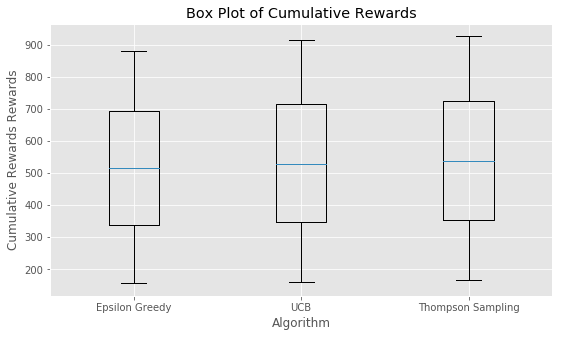

In [73]:
plt.figure(figsize = (9, 5))
fig = plt.boxplot([comparison_df[comparison_df['Algorithm'] == 'Epsilon Greedy']['Cumulative Reward'],
            comparison_df[comparison_df['Algorithm'] == 'UCB']['Cumulative Reward'],
            comparison_df[comparison_df['Algorithm'] == 'Thompson Sampling']['Cumulative Reward']])
plt.title('Box Plot of Cumulative Rewards')
plt.xlabel('Algorithm')
plt.ylabel('Cumulative Rewards Rewards')
plt.xticks([1, 2, 3], ['Epsilon Greedy', 'UCB', 'Thompson Sampling'])
plt.show()

In [52]:
# Export simulation data to CSV for analysis
comparison_df.to_csv('BanditRewards.csv', index = False)

In [43]:
# Compute mean reward and mean cumulative reward by time
results_df_eps_reduced = results_df_eps[['Time', 'Reward', 'Cumulative Reward', 'Arm']].copy()
results_df_eps_plotting = results_df_eps_reduced.groupby(['Time']).agg({'Reward': np.mean,
                                                                        'Cumulative Reward': np.mean,
                                                                        'Arm': lambda x: np.mean(x == ind_max(means))}).reset_index()
results_df_ucb_reduced = results_df_ucb[['Time', 'Reward', 'Cumulative Reward', 'Arm']].copy()
results_df_ucb_plotting = results_df_ucb_reduced.groupby(['Time']).agg({'Reward': np.mean,
                                                                        'Cumulative Reward': np.mean,
                                                                        'Arm': lambda x: np.mean(x == ind_max(means))}).reset_index()
results_df_thompson_reduced = results_df_thompson[['Time', 'Reward', 'Cumulative Reward', 'Arm']].copy()
results_df_thompson_plotting = results_df_thompson.groupby(['Time']).agg({'Reward': np.mean,
                                                                        'Cumulative Reward': np.mean,
                                                                        'Arm': lambda x: np.mean(x == ind_max(means))}).reset_index()

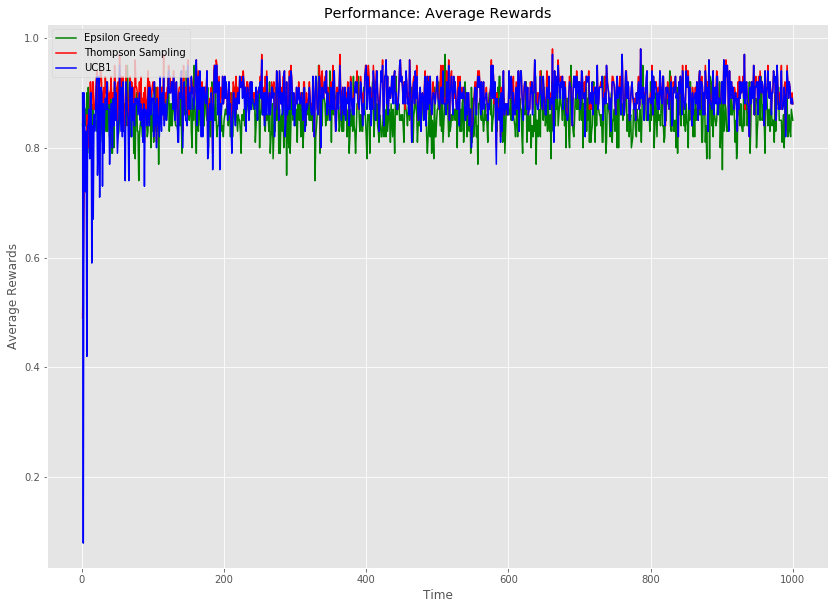

In [44]:
# Plot average reward by time for the 3 MABs
plt.figure(figsize = (14, 10))
plt.plot(results_df_eps_plotting['Time'], results_df_eps_plotting['Reward'], color = 'green', 
         label = 'Epsilon Greedy')
plt.plot(results_df_thompson_plotting['Time'], results_df_thompson_plotting['Reward'], color = 'red', 
         label = 'Thompson Sampling')
plt.plot(results_df_ucb_plotting['Time'], results_df_ucb_plotting['Reward'], color = 'blue', 
         label = 'UCB1')
plt.title('Performance: Average Rewards')
plt.xlabel('Time')
plt.ylabel('Average Rewards')
plt.legend(loc='upper left')
plt.show()

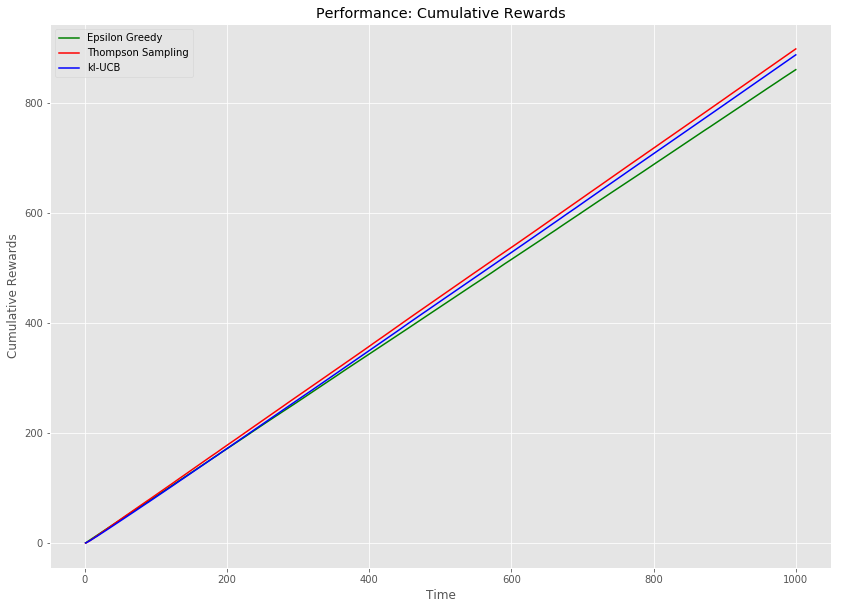

In [45]:
# Plot mean cumulative reward by time for the 3 MABs
plt.figure(figsize = (14, 10))
plt.plot(results_df_eps_plotting['Time'], results_df_eps_plotting['Cumulative Reward'], color = 'green', 
         label = 'Epsilon Greedy')
plt.plot(results_df_thompson_plotting['Time'], results_df_thompson_plotting['Cumulative Reward'], color = 'red', 
         label = 'Thompson Sampling')
plt.plot(results_df_ucb_plotting['Time'], results_df_ucb_plotting['Cumulative Reward'], color = 'blue', 
         label = 'kl-UCB')
plt.title('Performance: Cumulative Rewards')
plt.xlabel('Time')
plt.ylabel('Cumulative Rewards')
plt.legend(loc='upper left')
plt.show()

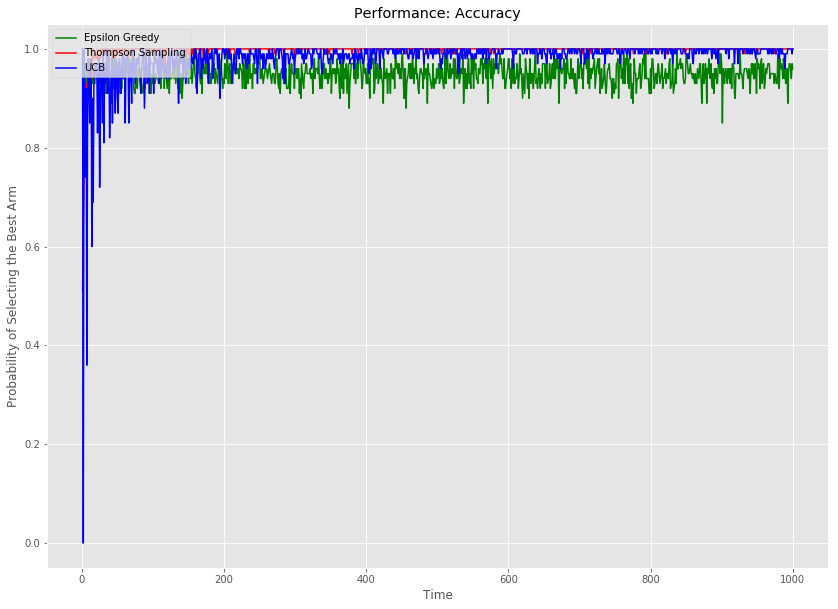

In [46]:
# Plot probability of selecting the best arm
plt.figure(figsize = (14, 10))
plt.plot(results_df_eps_plotting['Time'], results_df_eps_plotting['Arm'], color = 'green', 
         label = 'Epsilon Greedy')
plt.plot(results_df_thompson_plotting['Time'], results_df_thompson_plotting['Arm'], color = 'red', 
         label = 'Thompson Sampling')
plt.plot(results_df_ucb_plotting['Time'], results_df_ucb_plotting['Arm'], color = 'blue', 
         label = 'UCB')
plt.title('Performance: Accuracy')
plt.xlabel('Time')
plt.ylabel('Probability of Selecting the Best Arm')
plt.legend(loc='upper left')
plt.show()

### References ###

Burtini, Giuseppe & Loeppky, Jason & Lawrence, Ramon. (2015). A Survey of Online Experiment Design with the Stochastic Multi-Armed Bandit.   
White, J. (2013). Bandit Algorithms for Website Optimization. Sebastopol, Calif: O'Reilly.